<h1>Финальный проект "Прогнозирование оттока клиентов"</h1>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание данных**
Данные состоят из файлов, полученных из разных источников:
* contract.csv - информация о договоре;
* personal.csv - персональные данные клиента;
* internet.csv - информация об интернет услугах;
* phone.csv - информация об услугах телефонии.

**Цель проекта:**
Предсказать, ушел ли клиент или остался?

Бизнес метрика - это убытки по двум направлениям: 
1. Пользователю предложили промокоды , но он не собирался уходить (false positive)
2. Пользователю ничего не предложили и он ушёл (false negative) 
AUC-ROC  - метрика, которая учитывает возможность балансировать между false posititve и false negative

## Основной проект
### Предварительный анализ данных

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Необходимые библиотеки импортированы, все хорошо
    
</div>

In [2]:
try:
    df_contract = pd.read_csv('contract.csv', parse_dates=['BeginDate', 'EndDate'])
    df_personal = pd.read_csv('personal.csv')
    df_internet = pd.read_csv('internet.csv')
    df_phone = pd.read_csv('phone.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=['BeginDate', 'EndDate'])
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
    
df_contract.info()
display(df_contract.head())

df_personal.info()
display(df_personal.head())

df_internet.info()
display(df_internet.head())

df_phone.info()
display(df_phone.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Результаты предварительного анализа:
* contract: пропусков нет, `BeginDate` и `EndDate` требуется привести к типу `DateTime`, в `EndDate` встечается `No` в качестве значений
* personal: пропусков нет, с типами все ок
* internet: пропусков нет, с типами все ок
* phone: пропусков нет, с типами все ок

В последних двух таблицах данных меньше, чем в первых двух. Возможно, это связано с тем, что не все клиенты пользуются интернетом или телефонией.

### Предобработка и исследовательский анализ данных

#### Приведение типов
1. Даты приведем к нужным типам в момент считывания файлам
2. Переименование колонок с названиями не по стандарту
3. Анализ клиентов с TotalCharges = 0

In [3]:

df_personal.rename(columns={'gender':'Gender'}, inplace = True)

df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
df_contract['TotalCharges'].fillna(0, inplace = True)

In [4]:
df_contract[df_contract['TotalCharges'] == 0]['customerID'].count()

11

In [5]:
df_contract[df_contract['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


Всего 11 клиентов с нулевыми суммарными платежами , все они заристрировались в дату, на которую проводится анализ. Соответственно, это не техническая ошибка, так и должно быть. Если у нас предоплата, тогда корректно будет сделать присвоение TotalCharges = MonthlyCharges, но данных об этом нет.

#### Работа с пропусками

In [6]:
display(df_contract.isna().sum())
display(df_personal.isna().sum())
display(df_internet.isna().sum())
display(df_phone.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

customerID       0
Gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

customerID       0
MultipleLines    0
dtype: int64

Пропусков не обнаружено

#### Работа с дубликатами

In [7]:
display(df_contract.duplicated().sum())
display(df_personal.duplicated().sum())
display(df_internet.duplicated().sum())
display(df_phone.duplicated().sum())

0

0

0

0

Явных дубликатов не обнаружено

In [8]:
#Неявные дубликаты и аномальные строковые значения
def print_unique(df_name, df, cols):
    print(f'\n{df_name}')
    for col in cols: 
        print(f'{df_name}.{col}:', df[col].unique())

print_unique('df_contract', df_contract, ['Type', 'PaperlessBilling', 'PaymentMethod'])
print_unique('df_personal', df_personal, ['Gender', 'Partner', 'SeniorCitizen', 'Dependents'])
print_unique('df_internet', df_internet, ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                                          'TechSupport', 'StreamingTV', 'StreamingMovies'])
print_unique('df_phone', df_phone, ['MultipleLines'])


df_contract
df_contract.Type: ['Month-to-month' 'One year' 'Two year']
df_contract.PaperlessBilling: ['Yes' 'No']
df_contract.PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

df_personal
df_personal.Gender: ['Female' 'Male']
df_personal.Partner: ['Yes' 'No']
df_personal.SeniorCitizen: [0 1]
df_personal.Dependents: ['No' 'Yes']

df_internet
df_internet.InternetService: ['DSL' 'Fiber optic']
df_internet.OnlineSecurity: ['No' 'Yes']
df_internet.OnlineBackup: ['Yes' 'No']
df_internet.DeviceProtection: ['No' 'Yes']
df_internet.TechSupport: ['No' 'Yes']
df_internet.StreamingTV: ['No' 'Yes']
df_internet.StreamingMovies: ['No' 'Yes']

df_phone
df_phone.MultipleLines: ['No' 'Yes']


Неявных дубликатов и аномальных текстовых значений не обнаружено

array([[<AxesSubplot:title={'center':'SeniorCitizen'}>]], dtype=object)

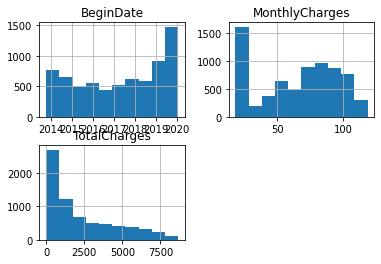

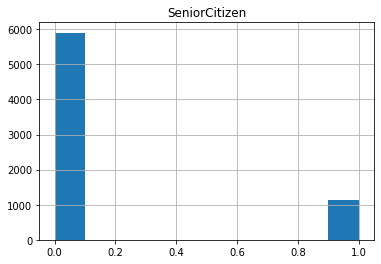

In [9]:
df_contract.hist()
df_personal.hist()

Тут также не видно аномалий в распределении

#### Формирование датасета для обучения, генерация новых признаков, удаление ненужных, выделение целевого

In [10]:
df = (df_contract.merge(df_personal, on='customerID', how='left')
                .merge(df_internet, on='customerID', how='left')
                .merge(df_phone, on='customerID', how='left')
     )
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [11]:
#Из-за меньшего кол-ва строк в последних двух таблицах будут пропуски, заполним их значениями "unknown", 
#т.к. остальные данные имеют ценность и не должны быть потеряны
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [12]:
df.fillna('unknown', inplace = True)
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [13]:
#Генерация целевого признака churned
df['Churned'] = (df['EndDate'] != 'No').astype(int)
#Генерируем доп.признак - длительность контракта
cur_date  = datetime.strptime('01/02/20', '%d/%m/%y')
df['Duration'] = (cur_date - df['BeginDate']).dt.days
##Больше даты не нужны, удаляем эти колонки, заодно выделяем целевой признак
target = df['Churned']
df.drop(columns=['BeginDate', 'EndDate', 'customerID'], inplace=True)
df

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churned,Duration
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,unknown,0,31
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,123
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,unknown,0,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
7039,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
7040,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,unknown,0,337
7041,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,1,215


#### Проверка корреляции признаков

<AxesSubplot:xlabel='TotalCharges', ylabel='Duration'>

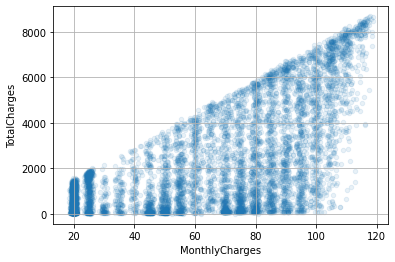

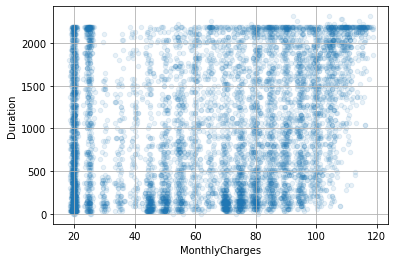

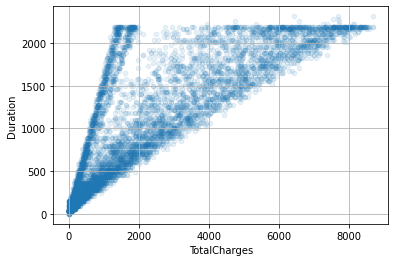

In [14]:
df.plot(kind='scatter', x='MonthlyCharges', y='TotalCharges', alpha=0.1, grid = True)
df.plot(kind='scatter', x='MonthlyCharges', y='Duration', alpha=0.1, grid = True)
df.plot(kind='scatter', x='TotalCharges', y='Duration', alpha=0.1, grid = True)

Можно сделать вывод, что между MonthlyCharges и TotalCharges есть корреляция на уровне верхней границы TotalCharges. А именно, для каждого значения MonthlyCharges есть порог TotalCharges, который не может быть превышен. Это логично, если платежи начислялись равномерно по месяцам. Можно также сказать, что не было существенного скачка цен . Вне пороговых значений  TotalCharges корреляции нет. Это объясняется тем, что абоненты более менее равномерно приходят и уходят.

Зависимость Duration от MonthlyCharges: самое равномерное распределение по длительности контракта у абонентов с минимальной месячными платежами, также видно, что среди наиболее лояльных клиентов выделяются те, кто платит ежемесячно больше всего.

Зависимость Duration от TotalCharges: ожидаемо, что суммарно больше платят те, кто дольше всех является абонентом. Также по графику видно, чем больше длительность контракта, тем сильнее растет разброс в TotalCharges. Это укладывается в здравый смысл, т.к. с течением времени абоненты с более высоким тарифом начинают сильнее обгонять абонентов с более низкими по суммарным платежам.

In [18]:
df[['MonthlyCharges', 'TotalCharges', 'Duration']].corr()

,MonthlyCharges,TotalCharges,Duration
MonthlyCharges,1.000000,0.651174,0.260860
TotalCharges,0.651174,1.000000,0.829418
Duration,0.260860,0.829418,1.000000


Обнаружена корреляция между признаками Duration и TotalCharges, равная 0.82. Это означает, что имеет место мультиколлинеарность. Чтобы ее исключить перед обучением в логистической регрессии удалим признак Duration

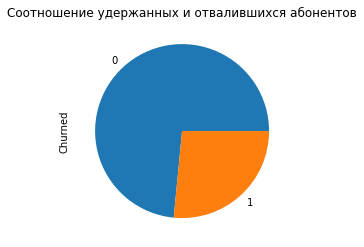

In [124]:
df.groupby('Churned')['Churned'].count().plot(kind='pie', title='Соотношение удержанных и отвалившихся абонентов')
plt.show()

Видно, что расторгли контракты около трети абонентов

Сравнение средних и медианных месячных платежей 

<BarContainer object of 2 artists>

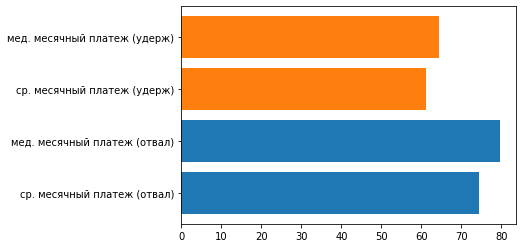

In [125]:
df_churned = df[df['Churned'] == 1]
x = ['ср. месячный платеж (отвал)', 'мед. месячный платеж (отвал)']
y = [df_churned['MonthlyCharges'].mean(), df_churned['MonthlyCharges'].median()]
plt.barh(x, y)

df_retained = df[df['Churned'] == 0]
x = ['ср. месячный платеж (удерж)', 'мед. месячный платеж (удерж)']
y = [df_retained['MonthlyCharges'].mean(), df_retained['MonthlyCharges'].median()]
plt.barh(x, y)

Сравнение средних и медианных LTV

<BarContainer object of 2 artists>

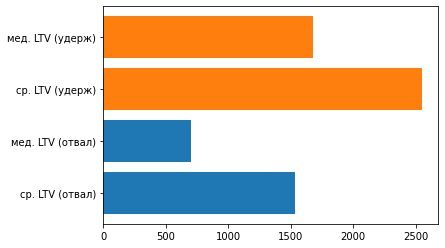

In [126]:
df_churned = df[df['Churned'] == 1]
x = ['ср. LTV (отвал)', 'мед. LTV (отвал)']
y = [df_churned['TotalCharges'].mean(), df_churned['TotalCharges'].median()]
plt.barh(x, y)

df_retained = df[df['Churned'] == 0]
x = ['ср. LTV (удерж)', 'мед. LTV (удерж)']
y = [df_retained['TotalCharges'].mean(), df_retained['TotalCharges'].median()]
plt.barh(x, y)

Сравнение средних и медианных длительностей контракта

<BarContainer object of 2 artists>

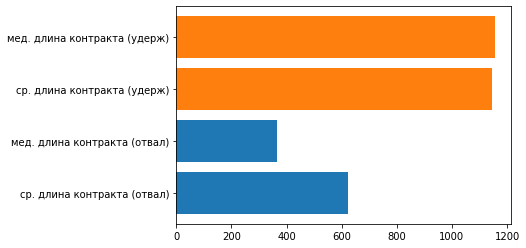

In [127]:
df_churned = df[df['Churned'] == 1]
x = ['ср. длина контракта (отвал)', 'мед. длина контракта (отвал)']
y = [df_churned['Duration'].mean(), df_churned['Duration'].median()]
plt.barh(x, y)

df_retained = df[df['Churned'] == 0]
x = ['ср. длина контракта (удерж)', 'мед. длина контракта (удерж)']
y = [df_retained['Duration'].mean(), df_retained['Duration'].median()]
plt.barh(x, y)

Если анализировать средние значения, то :
1. Видно, что абоненты, которые расторгли контракты, платили в среднем на 10 долларов больше в месяц, чем те, которые остались
2. Суммарной выручки они принесли в среднем на 1000 долларов меньше, но причина как раз в отвале
3. Длительность контракта у абонентов, расторгших контракт, в среднем в два раза меньше, чем у лояльных

Если анализировать медианы, то можно сделать выводы:
1. У абонентов, которые расторгли контракты, большая разница между средней и медианой, что означает, что среди них в основном абоненты с более низкой ежемесячной оплатой.
2. По LTV наоборот и длительности контракта, медиана  мельше, что означает, что в выборке преобладают абоненты с более высоким LTV и более длительными контрактами

Распределение месячных платежей 

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

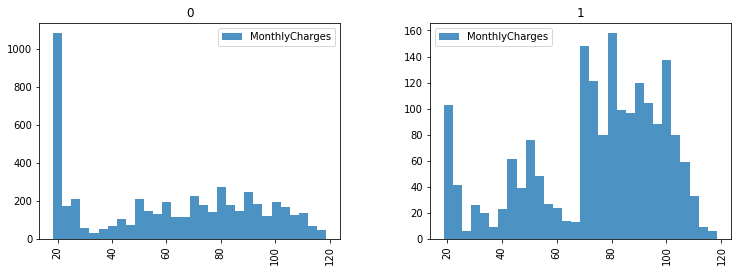

In [132]:
#ax = df_retained.hist(['TotalCharges'], bins=30, legend=True, alpha=0.8)
#df_churned.hist(['TotalCharges'], ax = ax, bins=30, legend=True, alpha=0.8)

df.hist(column = 'MonthlyCharges', by='Churned', bins=30, legend=True, alpha=0.8, figsize=(12,4))

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

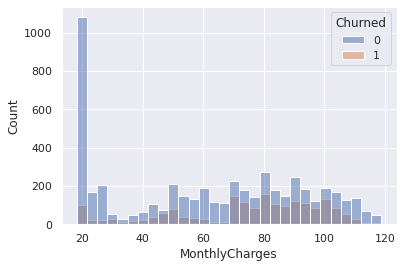

In [152]:
sns.set(style="darkgrid")
sns.histplot(df, x='MonthlyCharges', hue="Churned", bins=30, legend = True)


Распределение LTV

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

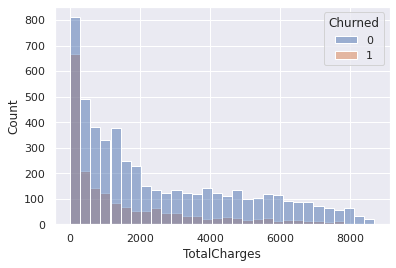

In [156]:
sns.histplot(df, x='TotalCharges', hue="Churned", bins=30, legend = True)

Распределение длин контракта

<AxesSubplot:xlabel='Duration', ylabel='Count'>

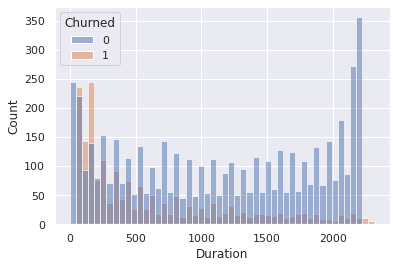

In [157]:
sns.histplot(df, x='Duration', hue="Churned", bins=50, legend = True)

Распределения показывают:
1. Среди лояльных клиентов существенно преобладают абоненты с минимальными месячными платежами, среди отвалившихся - существенных всплекс после платежа 70 долларов / мес
3. Активных спад по LTV у лояльных клиентов начинается после 2000 долларов. Можно обратить внимание на клиентов, которые уже принесли нам эту сумму и предложить другую программу лояльности.
2. Большинство абонетов в выборке имеют максимальную длительность контракта (пик на гистограмме), что говорит, о том, что они привлекались еще до даты начала анализа

Удалим целевой признак из датасета

In [53]:
df.drop(columns=['Churned'], inplace=True)

#### Деление выборки

In [54]:
features_train, features_test, target_train, target_test = (
    train_test_split(df, target, test_size=0.25, random_state=141122)
)
len(features_train), len(features_test)

(5282, 1761)

#### Кодирование признаков

In [82]:
#Для логистической регрессии - OHE
features_train_ohe = pd.get_dummies(features_train, drop_first=True) 
features_test_ohe = pd.get_dummies(features_test, drop_first=True) 

#Удаляем Duration из-за мультиколлинеарности
features_train_ohe.drop(columns=['Duration'], inplace=True)
features_test_ohe.drop(columns=['Duration'], inplace=True)

#Масштабирование для логистической регрессии
numeric = ['MonthlyCharges', 'TotalCharges']
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

display(features_train_ohe.head())
display(features_test_ohe.head())

,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,...,DeviceProtection_Yes,DeviceProtection_unknown,TechSupport_Yes,TechSupport_unknown,StreamingTV_Yes,StreamingTV_unknown,StreamingMovies_Yes,StreamingMovies_unknown,MultipleLines_Yes,MultipleLines_unknown
2143,0.336885,-0.043662,1,0,1,0,0,1,0,1,...,1,0,0,0,1,0,1,0,1,0
1783,0.230713,-0.975339,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1549,-0.625297,-0.986730,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
750,-0.265308,-0.277144,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5086,-1.469695,-0.596151,0,1,0,1,0,1,0,1,...,0,1,0,1,0,1,0,1,0,0


,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,...,DeviceProtection_Yes,DeviceProtection_unknown,TechSupport_Yes,TechSupport_unknown,StreamingTV_Yes,StreamingTV_unknown,StreamingMovies_Yes,StreamingMovies_unknown,MultipleLines_Yes,MultipleLines_unknown
1469,1.131515,0.527593,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
5403,0.713463,0.990540,0,0,0,1,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
5694,-0.439496,-0.230363,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
6846,0.492825,-0.971851,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
4452,0.721758,1.620231,0,0,1,0,1,0,0,0,...,1,0,1,0,1,0,1,0,0,0


In [83]:
l1 = set(features_train.columns)
l2 = set(features_test.columns)

if l1 == l2:
    print('После OHE-кодировки признаки идентичны.')
else:
    print(f'После OHE-кодировки признаки отличаются. Разница: {l1.symmetric_difference(l2)}')

После OHE-кодировки признаки идентичны.


In [84]:
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
cat_columns = ['Type','PaperlessBilling', 'PaymentMethod', 'Gender','Partner','Dependents','InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
features_train[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_test[cat_columns] = encoder.fit_transform(features_test[cat_columns])
display(features_train.head())
display(features_test.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Duration
2143,2.0,0.0,2.0,74.85,2181.75,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,914
1783,0.0,1.0,2.0,71.65,71.65,1.0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153
1549,0.0,1.0,3.0,45.85,45.85,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123
750,0.0,1.0,3.0,56.70,1652.95,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,822
5086,1.0,1.0,2.0,20.40,930.45,1.0,0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1401


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Duration
1469,0.0,0.0,0.0,98.80,3475.55,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1218
5403,0.0,1.0,2.0,86.20,4524.05,0.0,0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1645
5694,1.0,1.0,3.0,51.45,1758.90,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1006
6846,0.0,1.0,3.0,79.55,79.55,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,92
4452,2.0,0.0,1.0,86.45,5950.20,0.0,0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2132


### Подбор лучшей модели

In [85]:
#Подбор лучшей модели для логистической регрессии
model_lr = LogisticRegression(random_state=141122)
model_lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [87]:
%%time
warnings.filterwarnings("ignore")
parameters = {'fit_intercept':[True,False], 'solver':['lbfgs', 'liblinear'], 'max_iter':[50, 100]}
grid = GridSearchCV(model_lr, parameters, cv=5,
                    scoring='roc_auc')
grid.fit(features_train_ohe, target_train)
model_lr = grid.best_estimator_
print(f'Лучшие параметры логистической регрессии {grid.best_params_}')
print(f'Лучший roc_auc логистической регрессии {grid.best_score_:.2f}')

Лучшие параметры логистической регрессии {'fit_intercept': True, 'max_iter': 50, 'solver': 'lbfgs'}
Лучший roc_auc логистической регрессии 0.84
CPU times: user 6.46 s, sys: 8.7 s, total: 15.2 s
Wall time: 15.3 s


In [88]:
%%time
#Обучение модели для замера времени
model_lr.fit(features_train_ohe, target_train)

CPU times: user 162 ms, sys: 264 ms, total: 426 ms
Wall time: 403 ms


LogisticRegression(max_iter=50, random_state=141122)

In [89]:
#Случайный лес - подбор модели
model_rf = RandomForestClassifier(random_state=141122)
model_rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [90]:
%%time
parameters = { 
    "n_estimators"      : [10, 100],
    "max_features"      : ["auto", "sqrt", "log2"],
    "min_samples_split" : [2],
    "max_depth": [None, 1, 2, 3],
    "bootstrap": [True, False],
    } 
grid = GridSearchCV(model_rf, parameters, cv=5,
                    scoring='roc_auc')
grid.fit(features_train, target_train)
model_rf = grid.best_estimator_
print(f'Лучшие параметры модели случайного леса {grid.best_params_}')
print(f'Лучший roc_auc модели случайного леса  {grid.best_score_:.2f}')

Лучшие параметры модели случайного леса {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Лучший roc_auc модели случайного леса  0.88
CPU times: user 34.5 s, sys: 0 ns, total: 34.5 s
Wall time: 34.5 s


In [91]:
%%time
#Обучение модели для замера времени
model_rf.fit(features_train, target_train)

CPU times: user 438 ms, sys: 0 ns, total: 438 ms
Wall time: 443 ms


RandomForestClassifier(random_state=141122)

In [92]:
#LGBM - подбор модели
model_LightGBM = lgb.LGBMClassifier(random_state=141122)
model_LightGBM.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [93]:
%%time
parameters = { 
    'num_leaves': [7, 14, 21, 28],
    'learning_rate': [0.1, 0.03],
    'max_depth': [-1, 3],
    'n_estimators': [50, 100, 200],
    } 
grid = GridSearchCV(model_LightGBM, parameters, cv=5,
                    scoring='roc_auc')
grid.fit(features_train, target_train)
model_LightGBM = grid.best_estimator_
print(f'Лучшие параметры модели LGBM {grid.best_params_}')
print(f'Лучший roc_auc модели LGBM  {grid.best_score_:.2f}')

Лучшие параметры модели LGBM {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 28}
Лучший roc_auc модели LGBM  0.93
CPU times: user 2min 14s, sys: 385 ms, total: 2min 14s
Wall time: 2min 15s


In [94]:
%%time
#Обучение модели для замера времени
model_LightGBM.fit(features_train, target_train)

CPU times: user 1.66 s, sys: 26.6 ms, total: 1.68 s
Wall time: 1.7 s


LGBMClassifier(n_estimators=200, num_leaves=28, random_state=141122)

**Сравнение моделей на обучающей выборке**

№ | Модель | Гиперпараметры | roc_auc | Время обучения, сек. | 
---:|:---|:---:|:---:|:---:| 
1 | **Логистическая регрессия** | {'fit_intercept': True, 'max_iter': 50, 'solver': 'liblinear'} | 0.84 | 34.4 ms | 
2 | **Случайный лес** |  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100} | 0.88 | 476 ms| 
3 | **LGBM** | {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 28} | 0.93 | 5min 14s | 


Лучше всего себя показала модель на базе LGBM с метрикой roc_auc = 0.93, ее и стоит использовать для решения текущей задачи бизнеса, при этом время обучения у нее самое большое. Однако т.к. расчет не будет работать в real-time в данном случае качество модели важнее скорости работы.

### Проверка модели на тестовой выборке

In [95]:
%%time
predictions = model_LightGBM.predict(features_test)
roc_auc = roc_auc_score(target_test, model_LightGBM.predict_proba(features_test)[:, 1])
print("Метрика roc_auc на тестовой выборке: %.2f" % roc_auc)

Метрика roc_auc на тестовой выборке: 0.93
CPU times: user 94.2 ms, sys: 2.36 ms, total: 96.5 ms
Wall time: 95.6 ms


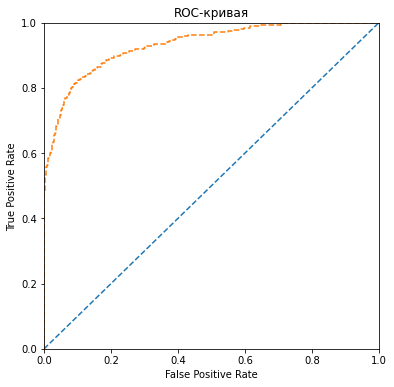

In [96]:
fpr, tpr, thresholds =  roc_curve(target_test, model_LightGBM.predict_proba(features_test)[:, 1]) 
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

<AxesSubplot:title={'center':'Оценка важности признаков'}, xlabel='Feature importance', ylabel='Features'>

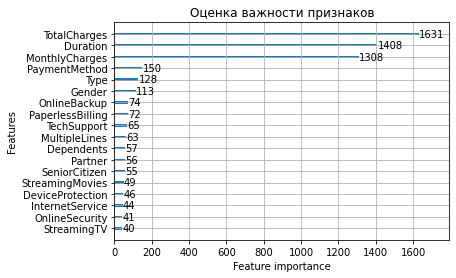

In [97]:
lgb.plot_importance(model_LightGBM, title='Оценка важности признаков')

### Вывод

Для решения поставленной задачи из трех моделей (логистическая регрессия, случайный лес, light GBM) была подобрана лучшая. Лучшей оказалось с light GBM с метрикой roc_auc = 0.93  Для нее также были подобраны гиперпараметры. 
На тестовой выборке метрика roc_auc составила также 0.93, что также является неплохим показателем и говорит о том, что переобучение не произошло.

Была проанализирована важность признаков для обучения модели. Самые важные:
* TotalCharges
* MonthlyCharges
* Duration
* PaymentMethod
* Type

Среди этих признаков есть PaymentMethod, который связан с процессом оплаты. Можно дать рекомендацию бизнесу по оптимизации процесса оплаты, чтобы понизить величину оттока клиентов


## Отчет о работе

Была проведена работа по созданию модели машинного обучения для предсказания оттока клиентов телеком-компании. Работа включала в себе:
* Предварительный анализ данных
* Предобработку данных
* Исследовательский анализ
* Подготовку признаков, подбор подходящей модели, обучение
* Запуск модели на тестовой выборке и анализ результатов

1. Размер обучающей выборки составил - 5282, тестовой -  1761.
2. Для обучения использовались следующие признаки: `Type`,`PaperlessBilling`,`PaymentMethod`,`MonthlyCharges`,`TotalCharges`,`Gender`,`SeniorCitizen`,`Partner`,`Dependents`,`InternetService`,`OnlineSecurity`,`OnlineBackup`,`DeviceProtection`,`TechSupport`,`StreamingTV`,`StreamingMovies`,`MultipleLines`,`Duration`. При обучении модели логистической регрессии признак `Duration` не использовался вследствие мультиколлинеарности
3. Лучшей моделью оказалась модель на базе light GBM с метрикой roc_auc = 0.93 как на обучающей, так и на тестовой выборках.  Для нее были подобраны гиперпараметры:
`{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 28}`
4. От первоначального плана работ работа отличается тем, что было проведено дополнительное исследование признаков на предмет мультиколлинеарности, оценка важности признаков,  а также кодирование признаков в итоге выполнялось после деления выборки на обучающую и тестовую.  Не хватило знания о том, что для линейной модели не подходит метод кодирования OrdinalEncoder, а нужно использовать метод OHE.
5. Ключевым этапом работы является этап по подбору подходящей модели. Им требуется уделять повышенное внимание. Однако, все этапы работы необходимы, т.к. конечный результат зафисит от многих факторов.
6. Трудности в работе: самая большая трудность -  понять,  с чего начинать. Но эта трудность решается благодаря предварительному составлению плана работ и подсказкам Тимлида. Вторая трудность - вспомнить все, чему учился последние полгода, и выбрать только нужное. Больших технических трудностей не было: задача укладывается в рамки пройденного на курсе материала.